In [417]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [418]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [419]:
# Load datasets
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'

In [420]:
# Load and process datasets
def load_and_process_data(data_path):
    df = pd.read_csv(data_path)
    if 'Price' in df.columns:
        if df['Price'].dtype == 'object':
            df['Price'] = df['Price'].str.replace(',', '').astype(float)
        return df['Price'].values.reshape(-1, 1)
    else:
        raise ValueError("Column 'Price' not found in the dataset.")

In [421]:
def reverse_dataset(dataset):
    return dataset[::-1]

In [422]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [423]:
def create_rescnn_model(input_shape):
    rescnn_input = Input(shape=input_shape)
    rescnn_conv1 = Conv1D(64, 3, activation='relu', padding='same')(rescnn_input)
    rescnn_pool1 = MaxPooling1D(2)(rescnn_conv1)
    rescnn_conv2 = Conv1D(64, 3, activation='relu', padding='same')(rescnn_pool1)
    rescnn_conv3 = Conv1D(64, 3, activation='relu', padding='same')(rescnn_conv2)
    rescnn_add1 = Concatenate()([rescnn_conv3, rescnn_pool1])
    rescnn_flatten = Flatten()(rescnn_add1)
    rescnn_dense = Dense(50, activation='relu')(rescnn_flatten)
    model = Model(inputs=rescnn_input, outputs=rescnn_dense)
    return model

In [424]:
def create_lstm_rescnn_model(input_shape):
    lstm_input = Input(shape=input_shape)
    lstm_layer = LSTM(50, return_sequences=True)(lstm_input)
    lstm_output = LSTM(50)(lstm_layer)

    rescnn_model = create_rescnn_model(input_shape)
    rescnn_input = Input(shape=input_shape)
    rescnn_output = rescnn_model(rescnn_input)

    merged = Concatenate()([lstm_output, rescnn_output])

    output = Dense(1)(merged)

    model = Model(inputs=[lstm_input, rescnn_input], outputs=output)

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [425]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [426]:
def train_lstm_rescnn_model(data, title):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    train_size = round(0.8 * len(df1))
    test_size = len(scaled_data) - train_size

    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]
    time_step = 100
    X_train_lstm, y_train_lstm = create_dataset(train_data, time_step)
    X_test_lstm, y_test_lstm = create_dataset(test_data, time_step)

    X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    model = create_lstm_rescnn_model((X_train_lstm.shape[1], 1))

    history = model.fit([X_train_lstm, X_train_lstm], y_train_lstm, validation_data=([X_test_lstm, X_test_lstm], y_test_lstm), epochs=20, batch_size=64, verbose=1)

    train_predict = model.predict([X_train_lstm, X_train_lstm])
    test_predict = model.predict([X_test_lstm, X_test_lstm])

    train_predict = scaler.inverse_transform(train_predict)
    y_train_lstm = scaler.inverse_transform([y_train_lstm]).flatten()
    test_predict = scaler.inverse_transform(test_predict)
    y_test_lstm = scaler.inverse_transform([y_test_lstm]).flatten()

    train_rmse = np.sqrt(np.mean(np.square(train_predict - y_train_lstm)))
    test_rmse = np.sqrt(np.mean(np.square(test_predict - y_test_lstm)))
    print(f'{title} Training RMSE: {train_rmse}')
    print(f'{title} Testing RMSE: {test_rmse}')

    # Plot final results
    plt.figure(figsize=(10, 6))

    # Plot training data
    plt.plot(np.arange(len(train_data)), scaler.inverse_transform(train_data), label='Training Data')

    # Plot testing data
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Testing Data')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'LSTM-ResCNN Model Results for {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [429]:
def train_and_predict_30_days(data, title):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    time_step = 100
    X_train_lstm, y_train_lstm = create_dataset(scaled_data, time_step)
    X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

    model = create_lstm_rescnn_model((X_train_lstm.shape[1], 1))

    history = model.fit([X_train_lstm, X_train_lstm], y_train_lstm, epochs=20, batch_size=64, verbose=1)

    # Predict the next 30 days
    last_100_days = scaled_data[-time_step:].reshape(1, -1, 1)
    next_30_days = []

    for i in range(30):
        prediction = model.predict([last_100_days, last_100_days])
        next_30_days.append(prediction[0, 0])
        last_100_days = np.append(last_100_days[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Inverse scale the predicted values
    next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot actual data
    plt.plot(np.arange(len(data)), data, label='Actual Data')

    # Plot predicted data
    plt.plot(np.arange(len(data), len(data) + 30), next_30_days, label='Predicted Data')

    # Plot testing data
    test_size = int(len(scaled_data) * 0.2)
    plt.plot(np.arange(len(data) - test_size, len(data)), data[-test_size:], label='Testing Data', color='green')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Next 30 Days Prediction using LSTM-ResCNN Model for {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

Bitcoin data shape: (4111, 1)
NASDAQ data shape: (2833, 1)
USD data shape: (2907, 1)
Epoch 1/20
63/63 [==============================] - 16s 174ms/step - loss: 0.0037
Epoch 2/20
63/63 [==============================] - 12s 184ms/step - loss: 7.2312e-04
Epoch 3/20
63/63 [==============================] - 9s 151ms/step - loss: 4.7251e-04
Epoch 4/20
63/63 [==============================] - 11s 177ms/step - loss: 4.8436e-04
Epoch 5/20
63/63 [==============================] - 13s 207ms/step - loss: 3.7074e-04
Epoch 6/20
63/63 [==============================] - 10s 159ms/step - loss: 2.7105e-04
Epoch 7/20
63/63 [==============================] - 11s 175ms/step - loss: 1.7425e-04
Epoch 8/20
63/63 [==============================] - 12s 187ms/step - loss: 1.7134e-04
Epoch 9/20
63/63 [==============================] - 16s 258ms/step - loss: 1.6843e-04
Epoch 10/20
63/63 [==============================] - 12s 184ms/step - loss: 1.7277e-04
Epoch 11/20
63/63 [==============================] - 10s 15

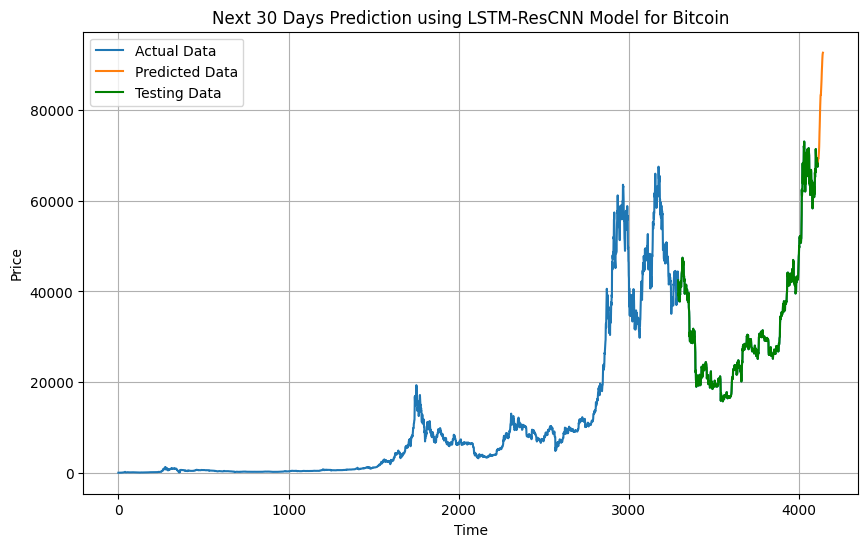

Epoch 1/20
43/43 [==============================] - 11s 133ms/step - loss: 0.0105
Epoch 2/20
43/43 [==============================] - 8s 179ms/step - loss: 0.0013
Epoch 3/20
43/43 [==============================] - 5s 127ms/step - loss: 8.4536e-04
Epoch 4/20
43/43 [==============================] - 7s 163ms/step - loss: 6.5730e-04
Epoch 5/20
43/43 [==============================] - 6s 136ms/step - loss: 5.2423e-04
Epoch 6/20
43/43 [==============================] - 5s 128ms/step - loss: 4.6148e-04
Epoch 7/20
43/43 [==============================] - 7s 163ms/step - loss: 4.4104e-04
Epoch 8/20
43/43 [==============================] - 5s 126ms/step - loss: 4.2203e-04
Epoch 9/20
43/43 [==============================] - 8s 184ms/step - loss: 4.0895e-04
Epoch 10/20
43/43 [==============================] - 6s 143ms/step - loss: 3.2550e-04
Epoch 11/20
43/43 [==============================] - 8s 189ms/step - loss: 3.4532e-04
Epoch 12/20
43/43 [==============================] - 5s 125ms/step - l

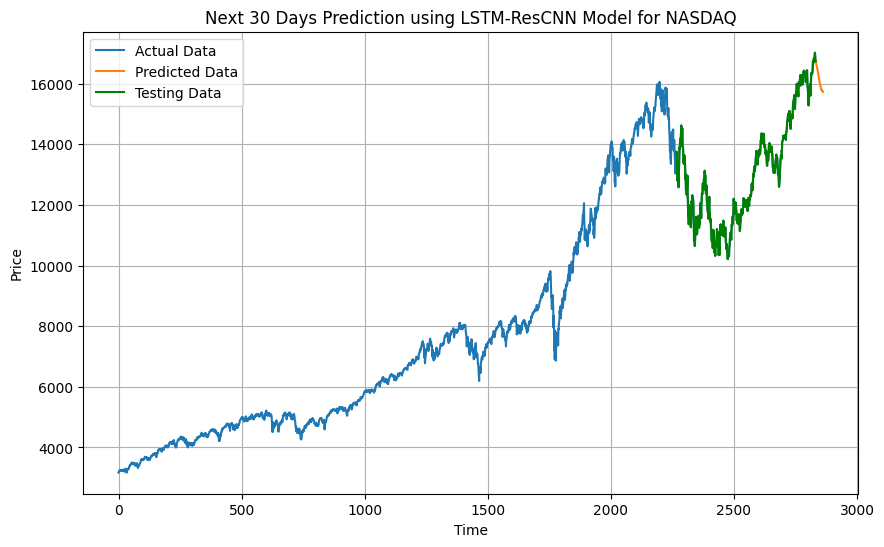

Epoch 1/20
44/44 [==============================] - 12s 162ms/step - loss: 0.0112
Epoch 2/20
44/44 [==============================] - 6s 145ms/step - loss: 0.0011
Epoch 3/20
44/44 [==============================] - 6s 145ms/step - loss: 7.5642e-04
Epoch 4/20
44/44 [==============================] - 7s 163ms/step - loss: 6.2330e-04
Epoch 5/20
44/44 [==============================] - 6s 129ms/step - loss: 4.8673e-04
Epoch 6/20
44/44 [==============================] - 8s 175ms/step - loss: 4.2830e-04
Epoch 7/20
44/44 [==============================] - 5s 124ms/step - loss: 3.4272e-04
Epoch 8/20
44/44 [==============================] - 7s 161ms/step - loss: 3.8495e-04
Epoch 9/20
44/44 [==============================] - 6s 136ms/step - loss: 2.9088e-04
Epoch 10/20
44/44 [==============================] - 6s 136ms/step - loss: 2.7980e-04
Epoch 11/20
44/44 [==============================] - 7s 154ms/step - loss: 2.7800e-04
Epoch 12/20
44/44 [==============================] - 6s 131ms/step - l

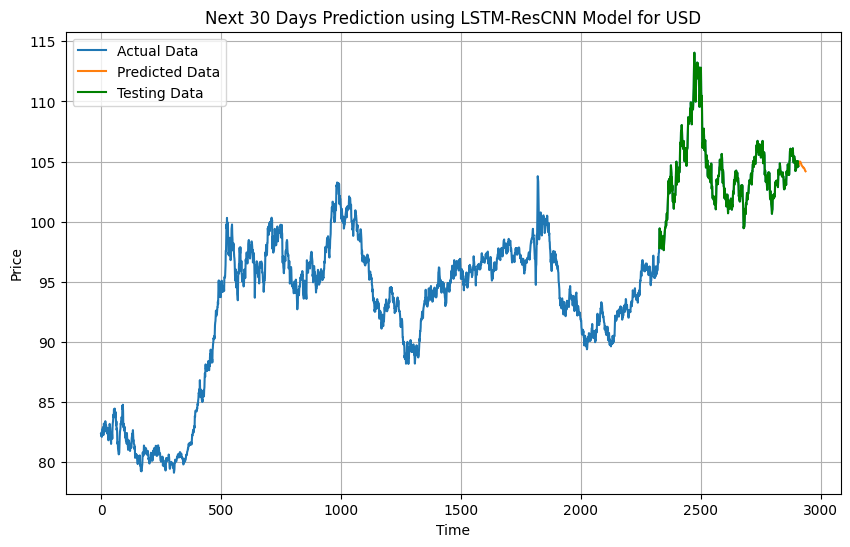

In [428]:
# Load datasets
bitcoin_data = load_and_process_data(bitcoin_data_path)
nasdaq_data = load_and_process_data(nasdaq_data_path)
usd_data = load_and_process_data(usd_data_path)

# Reverse datasets to correct chronological order
bitcoin_data = reverse_dataset(bitcoin_data)
nasdaq_data = reverse_dataset(nasdaq_data)
usd_data = reverse_dataset(usd_data)

print("Bitcoin data shape:", bitcoin_data.shape)
print("NASDAQ data shape:", nasdaq_data.shape)
print("USD data shape:", usd_data.shape)

train_and_predict_30_days(bitcoin_data, 'Bitcoin')
train_and_predict_30_days(nasdaq_data, 'NASDAQ')
train_and_predict_30_days(usd_data, 'USD')